### STEP-1: Clean & Align Dataset-1

We will convert Dataset-1 into the same physics format as Dataset-2.

dataset 1 og-  District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link
Convert to: N | P | K | temperature | humidity | ph | rainfall | label | District_Name | Fertilizer |

In [14]:
import os
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

# Visualization
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

### STEP 1 — Load raw advisory table ONCE

In [90]:
advisory = pd.read_csv("/Users/sayenaqureshi/Main-Folder/datasets/Crop and fertilizer dataset (2).csv")

advisory['crop_clean'] = advisory['Crop'].astype(str).str.lower().str.strip()
advisory_lookup = advisory[['crop_clean','Link']].dropna()


In [15]:
df1 = pd.read_csv("/Users/sayenaqureshi/Main-Folder/datasets/Crop and fertilizer dataset (2).csv")

df1 = df1.rename(columns={
    'Nitrogen':'N',
    'Phosphorus':'P',
    'Potassium':'K',
    'Temperature':'temperature',
    'Rainfall':'rainfall',
    'pH':'ph',
    'Crop':'label'
})

df1['humidity'] = None  # dataset-1 has no humidity

df1 = df1[['N','P','K','temperature','humidity','ph','rainfall','label','District_Name','Fertilizer']]

df1.head()


,N,P,K,temperature,humidity,ph,rainfall,label,District_Name,Fertilizer
0,75,50,100,20,None,6.5,1000,Sugarcane,Kolhapur,Urea
1,80,50,100,20,None,6.5,1000,Sugarcane,Kolhapur,Urea
2,85,50,100,20,None,6.5,1000,Sugarcane,Kolhapur,Urea
3,90,50,100,20,None,6.5,1000,Sugarcane,Kolhapur,Urea
4,95,50,100,20,None,6.5,1000,Sugarcane,Kolhapur,Urea


In [11]:
df1.shape

(4513, 10)

### Clean & Align Dataset-2

In [16]:
df2 = pd.read_csv("/Users/sayenaqureshi/Main-Folder/datasets/Crop_recommendation (3).csv")

# Add missing metadata columns so structure matches df1
df2['District_Name'] = None
df2['Fertilizer'] = None

df2 = df2[['N','P','K','temperature','humidity','ph','rainfall','label','District_Name','Fertilizer']]
df2.head()


,N,P,K,temperature,humidity,ph,rainfall,label,District_Name,Fertilizer
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,None,None
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,None,None
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,None,None
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,None,None
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,None,None


In [12]:
df2.shape

(2200, 10)

### STEP-3: Merge Both Dataset

In [6]:
df_master = pd.concat([df1, df2], ignore_index=True)
df_master.head()


/var/folders/j1/jm46_jgd3v317d78k416zvd80000gn/T/ipykernel_36759/3916968283.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_master = pd.concat([df1, df2], ignore_index=True)


,N,P,K,temperature,humidity,ph,rainfall,label,District_Name,Fertilizer
0,75,50,100,20.0,NaN,6.5,1000.0,Sugarcane,Kolhapur,Urea
1,80,50,100,20.0,NaN,6.5,1000.0,Sugarcane,Kolhapur,Urea
2,85,50,100,20.0,NaN,6.5,1000.0,Sugarcane,Kolhapur,Urea
3,90,50,100,20.0,NaN,6.5,1000.0,Sugarcane,Kolhapur,Urea
4,95,50,100,20.0,NaN,6.5,1000.0,Sugarcane,Kolhapur,Urea


In [13]:
df_master.shape

(6713, 10)

In [17]:
### 🧪 EDA STEP-0 : Data Integrity & Statistics

In [18]:
print("=== Dataset Shape ===")
print(df_master.shape)

print("\n=== Missing Values ===")
print(df_master.isnull().sum())

print("\n=== Duplicate Rows ===")
print("Duplicates:", df_master.duplicated().sum())

print("\n=== Descriptive Statistics ===")
df_master[['N','P','K','temperature','humidity','ph','rainfall']].describe()


=== Dataset Shape ===
(6713, 10)

=== Missing Values ===
N                   0
P                   0
K                   0
temperature         0
humidity         4513
ph                  0
rainfall            0
label               0
District_Name    2200
Fertilizer       2200
dtype: int64

=== Duplicate Rows ===
Duplicates: 0

=== Descriptive Statistics ===


,N,P,K,temperature,humidity,ph,rainfall
count,6713.000000,6713.000000,6713.000000,6713.000000,2200.000000,6713.000000,6713.000000
mean,80.708923,54.021004,58.533145,25.817181,71.481779,6.634717,584.629829
std,43.170800,23.256313,41.825274,5.639107,22.263812,0.687246,395.558320
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,40.000000,40.000000,30.000000,21.323763,60.261953,6.000000,131.090008
50%,85.000000,55.000000,49.000000,25.000000,80.473146,6.500000,600.000000
75%,120.000000,65.000000,65.000000,30.000000,89.948771,7.000000,900.000000
max,150.000000,145.000000,205.000000,43.675493,99.981876,9.935091,1700.000000


### conclusion

Dataset Overview

After merging Dataset-1 and Dataset-2, the final master dataset contains:

6,713 records and 10 columns, representing a large and diverse agronomic dataset.

Missing Value Analysis
| Feature                                   | Missing Values | Interpretation                   |
| ----------------------------------------- | -------------- | -------------------------------- |
| N, P, K, temperature, ph, rainfall, label | 0              | Fully complete physics data      |
| humidity                                  | 4,513          | Missing for Dataset-1 (expected) |
| District_Name                             | 2,200          | Missing for Dataset-2            |
| Fertilizer                                | 2,200          | Missing for Dataset-2            |

Interpretation

The missing values are structural, not erroneous — they result from merging two different datasets with different information scopes.
No missing values exist in the core physics features, which confirms that model training will not be affected.

Duplicate Analysis

No duplicate records were found in the merged dataset, ensuring data uniqueness and preventing model bias.


Descriptive Statistics Summary
| Feature        | Range            | Mean    | Interpretation                       |
| -------------- | ---------------- | ------- | ------------------------------------ |
| Nitrogen (N)   | 0 – 150          | 80.70   | Wide nutrient diversity              |
| Phosphorus (P) | 5 – 145          | 54.02   | Balanced phosphorus levels           |
| Potassium (K)  | 5 – 205          | 58.53   | Strong variation for different crops |
| Temperature    | 8.82°C – 43.67°C | 25.81°C | Covers tropical to warm climates     |
| Humidity       | 14% – 99%        | 71.48%  | Reflects moist agricultural climates |
| pH             | 3.50 – 9.93      | 6.63    | Slightly acidic to alkaline soils    |
| Rainfall       | 20 mm – 1700 mm  | 584 mm  | Wide rainfall diversity              |


### NEXT STEPS

Next Steps
Data Distributions

We visualize the distribution of each continuous feature to understand their spread, detect skewness, and identify any unusual patterns.

Outlier Detection

Boxplots are used to visually inspect potential outliers in nutrient, climatic, and pH values. In agriculture, these extreme values may represent real field conditions rather than noise.

Correlation Analysis

We analyze how soil and climate features correlate with each other to ensure that no severe multicollinearity exists before training the machine learning model.

The variable corr represents a DataFrame where each cell contains the correlation coefficient between two continuous features after removing the target variable (label).
Correlation values range from -1 to 1, where:

1 indicates a perfect positive correlation

-1 indicates a perfect negative correlation

0 indicates no correlation

This analysis ensures the dataset is statistically suitable for building a robust crop recommendation model.

### 🧪 NEXT STEP–1: Univariate Distribution Analysis (Histograms)

To understand the spread, skewness, and overall distribution of each soil and climate feature.

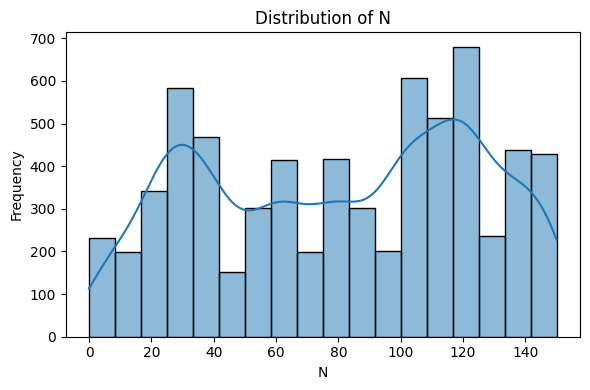

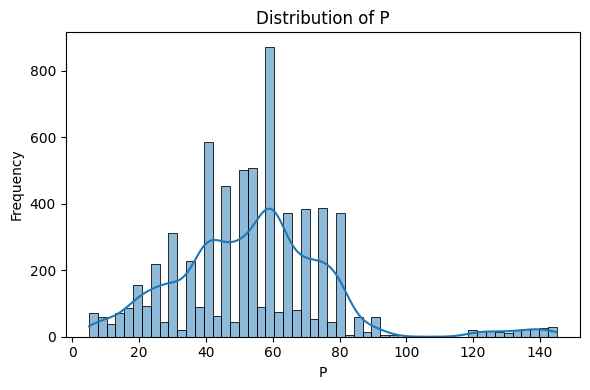

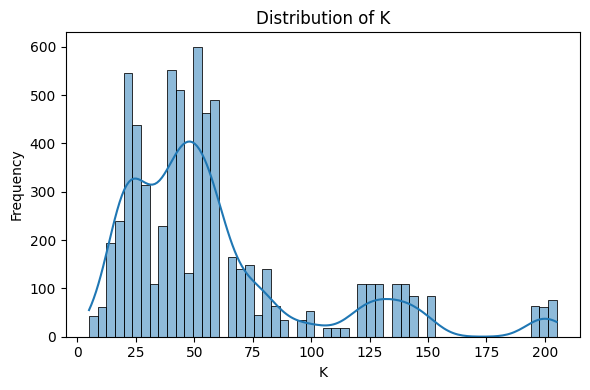

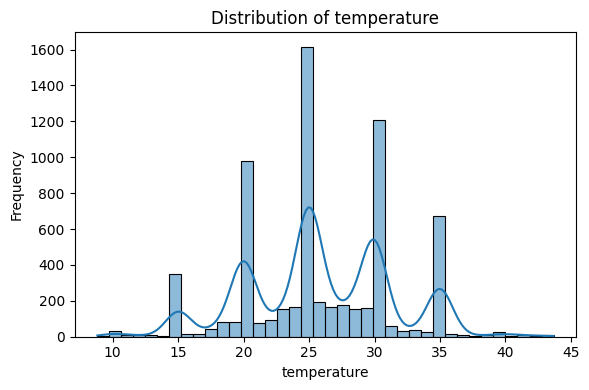

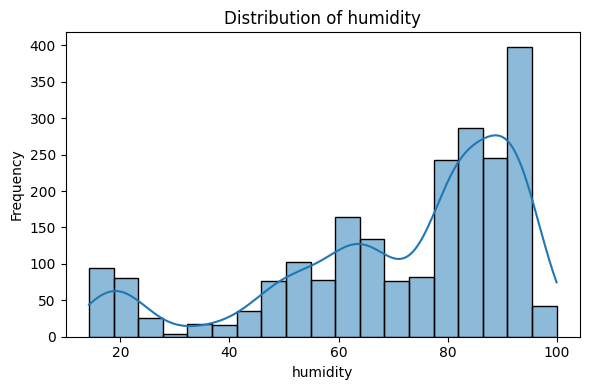

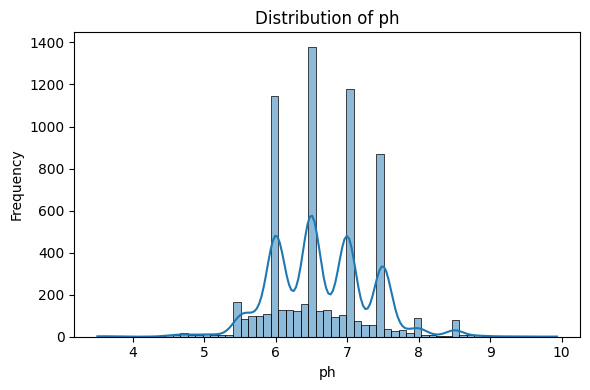

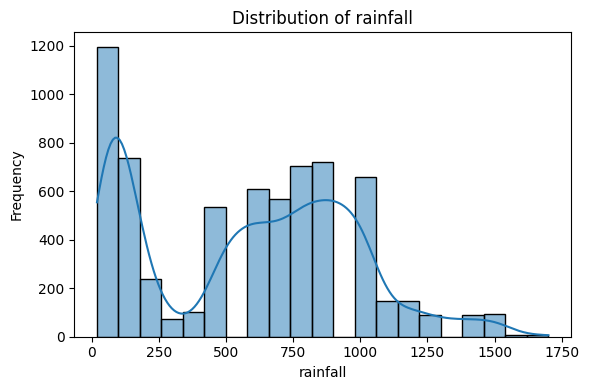

In [22]:


features = ['N','P','K','temperature','humidity','ph','rainfall']

for feature in features:
    plt.figure(figsize=(6,4))
    sns.histplot(df_master[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


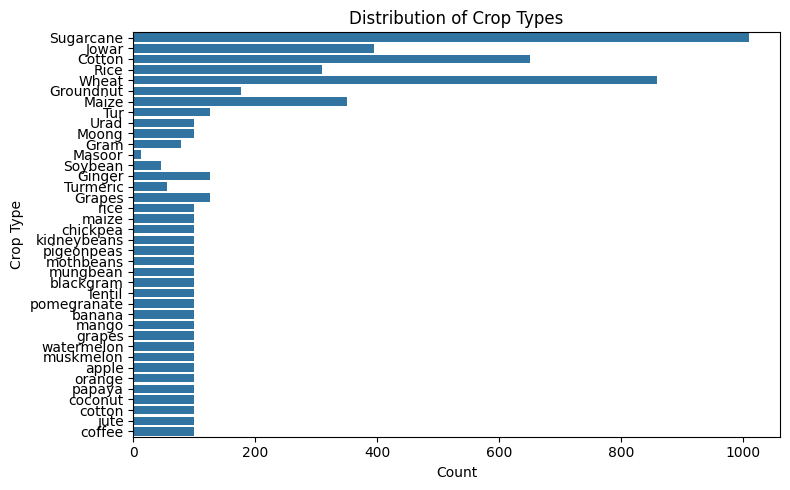

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(y=df_master['label'])
plt.title("Distribution of Crop Types")
plt.xlabel("Count")
plt.ylabel("Crop Type")
plt.tight_layout()
plt.show()


### conclusions


Continuous Variables

The histograms show the distributions of each continuous variable:

| Variable        | Description                                                                                                                                                                                                     |
| --------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **N, P, K**     | These soil nutrients show varied distributions with wide ranges. Some display multimodal behavior, suggesting the presence of different nutrient requirement groups corresponding to different crop categories. |
| **Temperature** | Appears approximately normally distributed, centered around 25–26°C, representing typical agricultural climate conditions.                                                                                      |
| **Humidity**    | Shows a left-skewed distribution, with a high concentration of values in the higher humidity range, indicating that most crop samples come from humid agricultural environments.                                |
| **pH**          | Fairly normally distributed and slightly skewed toward acidic soils (values below 7), which is consistent with typical crop-growing soil conditions.                                                            |
| **Rainfall**    | Displays a right-skewed distribution, where extremely high rainfall values are less frequent but present, reflecting diverse climatic zones ranging from semi-arid to high-rainfall regions.                    |

Categorical Variable

The bar plot of the label (Crop Type) indicates that the dataset contains multiple crop classes with well-distributed samples, which supports stable and unbiased multi-class classification.


### 🧪 Outlier Detection — Boxplot Analysis

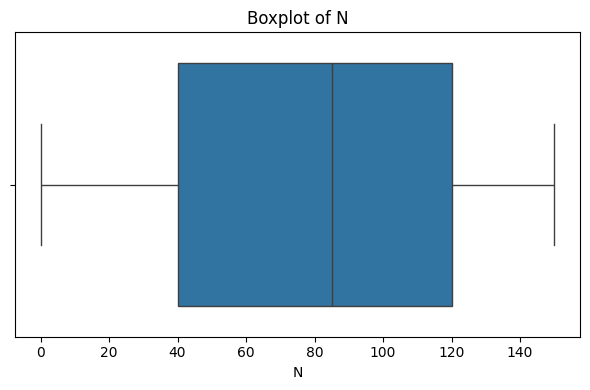

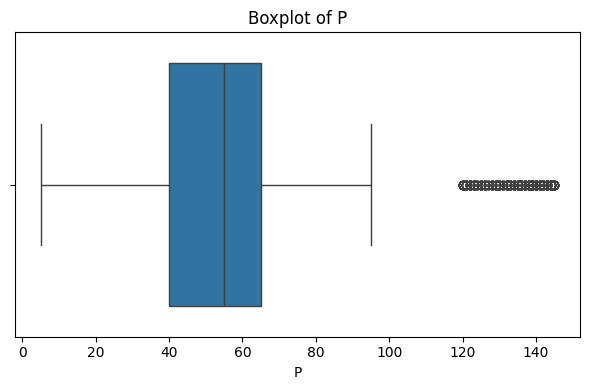

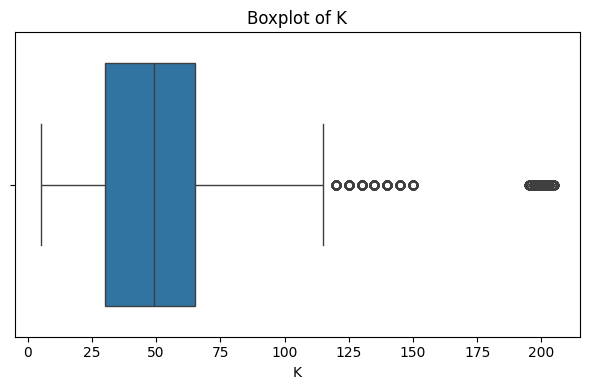

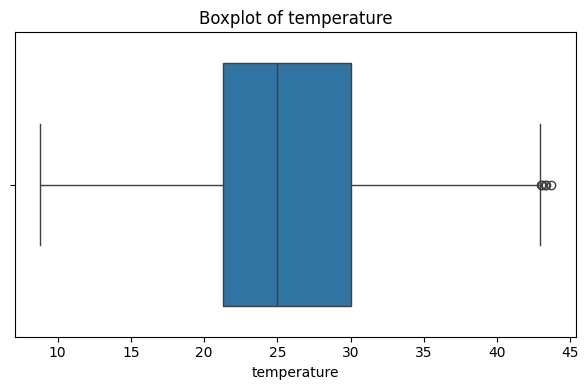

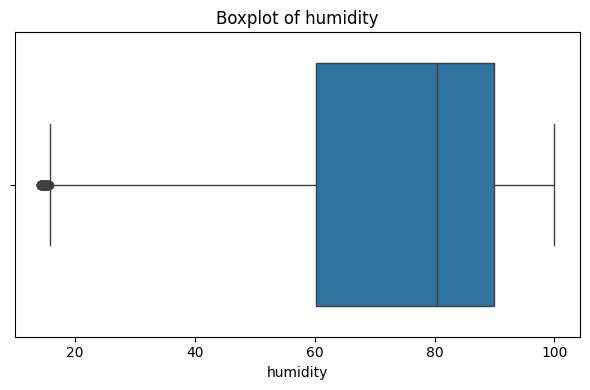

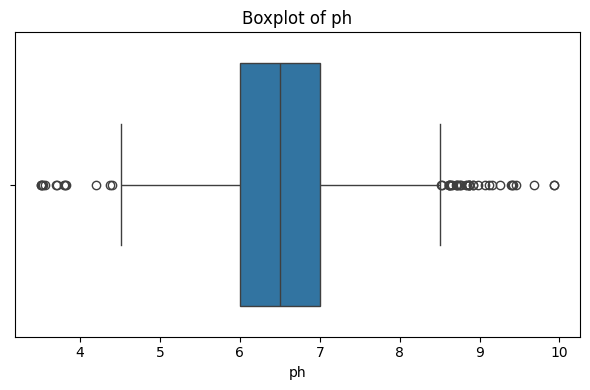

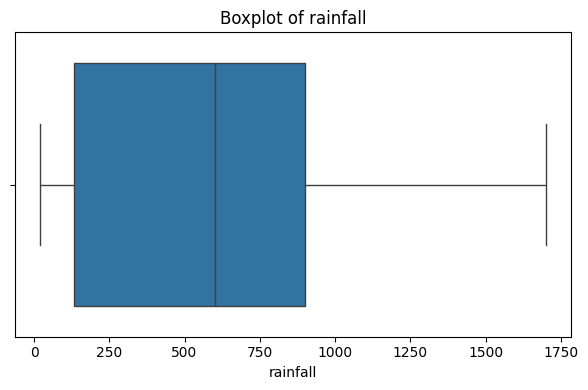

In [24]:
features = ['N','P','K','temperature','humidity','ph','rainfall']

for feature in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_master[feature])
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()
    plt.show()


### conclusion of boxplot

Outlier Detection

The boxplots provide insights into potential outliers in the continuous variables:
| Feature         | Observation                                                                                                                                                  |
| --------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **N, P, K**     | Several high-end outliers are observed, representing crops that require higher nutrient levels. These values are agronomically valid and therefore retained. |
| **Temperature** | Few low and high-end outliers are visible, reflecting extreme climatic conditions in certain regions.                                                        |
| **Humidity**    | Some low-end outliers exist, indicating very dry environmental conditions for specific crops.                                                                |
| **pH**          | Both acidic and alkaline extremes are observed, which are valid soil conditions for particular crops.                                                        |
| **Rainfall**    | High-end outliers indicate heavy rainfall zones and monsoon-influenced regions.                                                                              |


Conclusion on Outliers

The outliers are considered real-world agricultural variations rather than noise, and therefore are preserved to maintain the model’s ability to generalize across diverse farming conditions.



### 🧪 Bivariate Analysis — Feature vs Crop Relationships

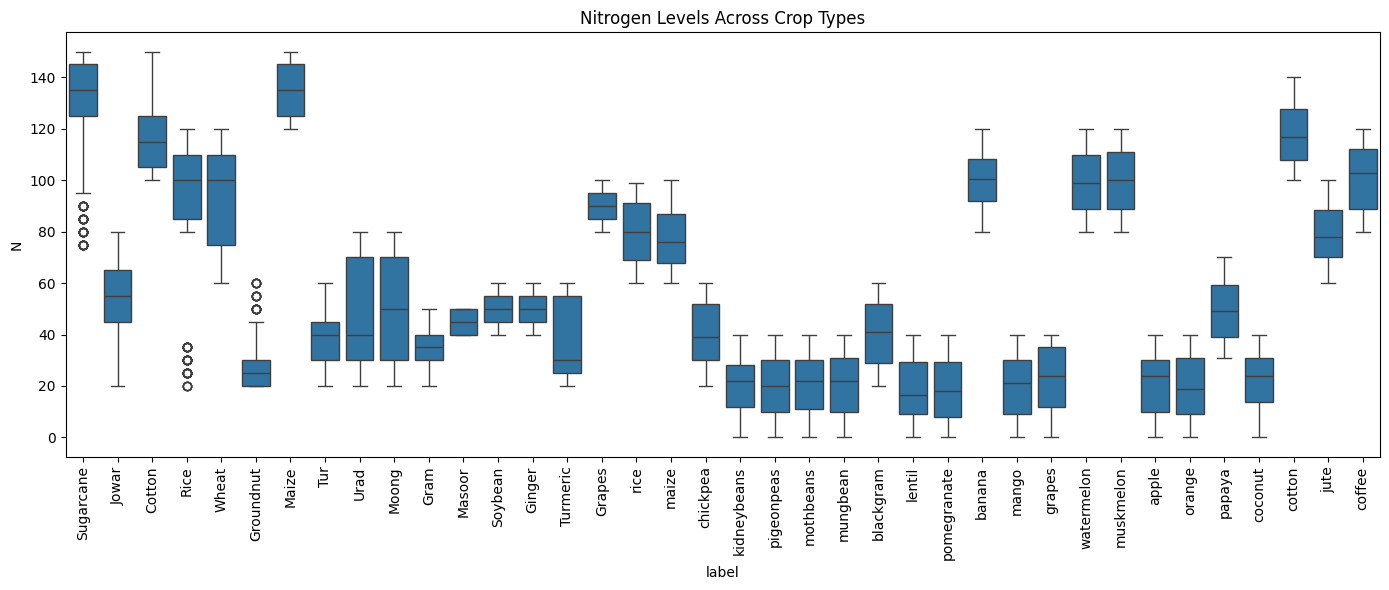

In [25]:
plt.figure(figsize=(14,6))
sns.boxplot(x='label', y='N', data=df_master)
plt.xticks(rotation=90)
plt.title("Nitrogen Levels Across Crop Types")
plt.tight_layout()
plt.show()


Bivariate Analysis

Boxplots were used to study the relationship between soil nutrients and crop types.

Nitrogen vs Crop Type:
The boxplot demonstrates that different crops require significantly different nitrogen ranges. Certain crops such as rice, sugarcane, and maize show higher median nitrogen levels, while legumes such as lentil and chickpea require comparatively lower nitrogen levels. This confirms that nitrogen is a critical determinant of crop suitability.

### 🧪 Bivariate Analysis — Phosphorus vs Crop

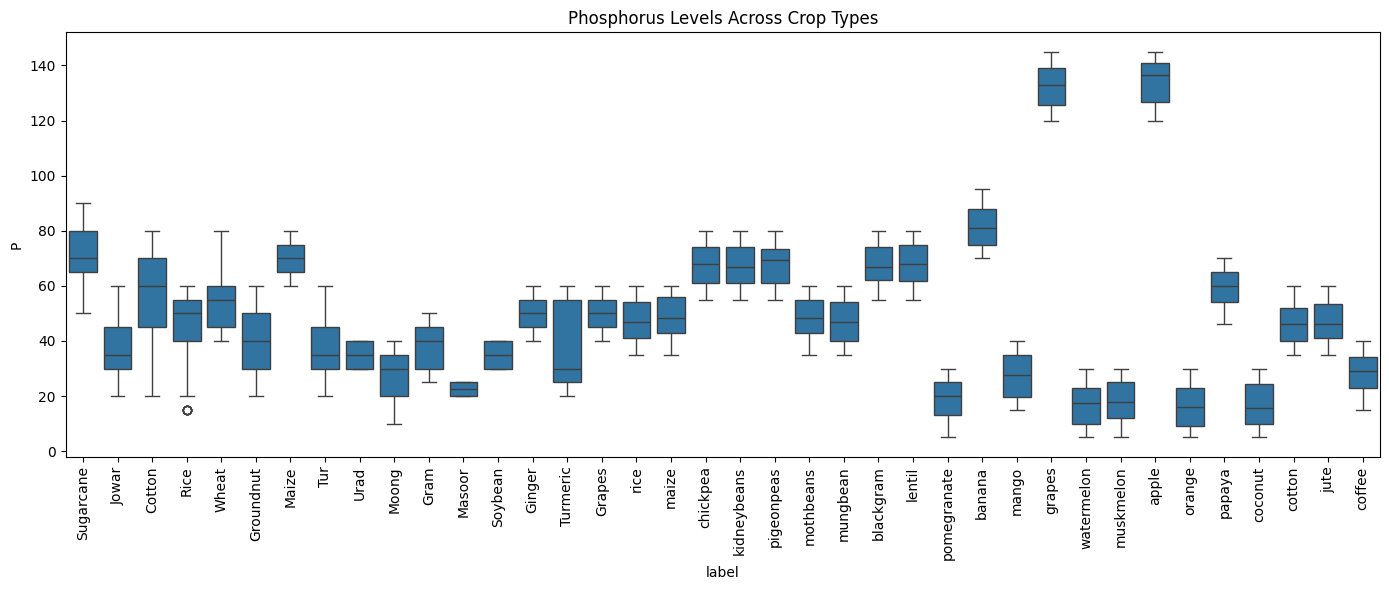

In [27]:
plt.figure(figsize=(14,6))
sns.boxplot(x='label', y='P', data=df_master)
plt.xticks(rotation=90)
plt.title("Phosphorus Levels Across Crop Types")
plt.tight_layout()
plt.show()


Phosphorus vs Crop Type

The boxplot illustrates the distribution of phosphorus levels required by different crops.

Observation:
Distinct variation in phosphorus content is observed across crop categories. Crops such as cereals and fruit-bearing plants tend to require moderate to high phosphorus levels, while legumes typically exhibit lower median phosphorus requirements. The clear separation between crop-wise phosphorus ranges demonstrates that phosphorus is a significant contributor to crop differentiation.


### 🧪 Bivariate Analysis — Potassium vs Crop

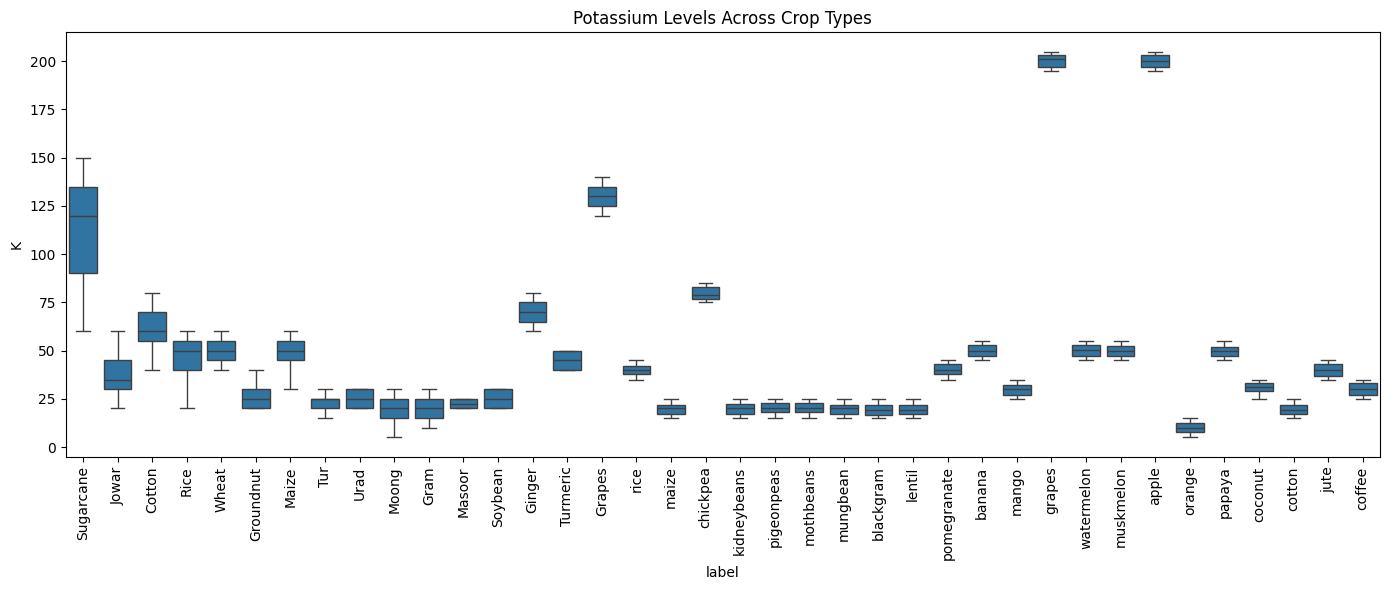

In [28]:
plt.figure(figsize=(14,6))
sns.boxplot(x='label', y='K', data=df_master)
plt.xticks(rotation=90)
plt.title("Potassium Levels Across Crop Types")
plt.tight_layout()
plt.show()


Observation:
Crops such as banana, coconut, and sugarcane exhibit higher potassium requirements, whereas pulses and legumes show comparatively lower potassium ranges. This variation confirms that potassium plays a crucial role in determining crop suitability and is an important discriminative feature for the crop recommendation model.

### 🧪 Bivariate Analysis — Temperature vs Crop

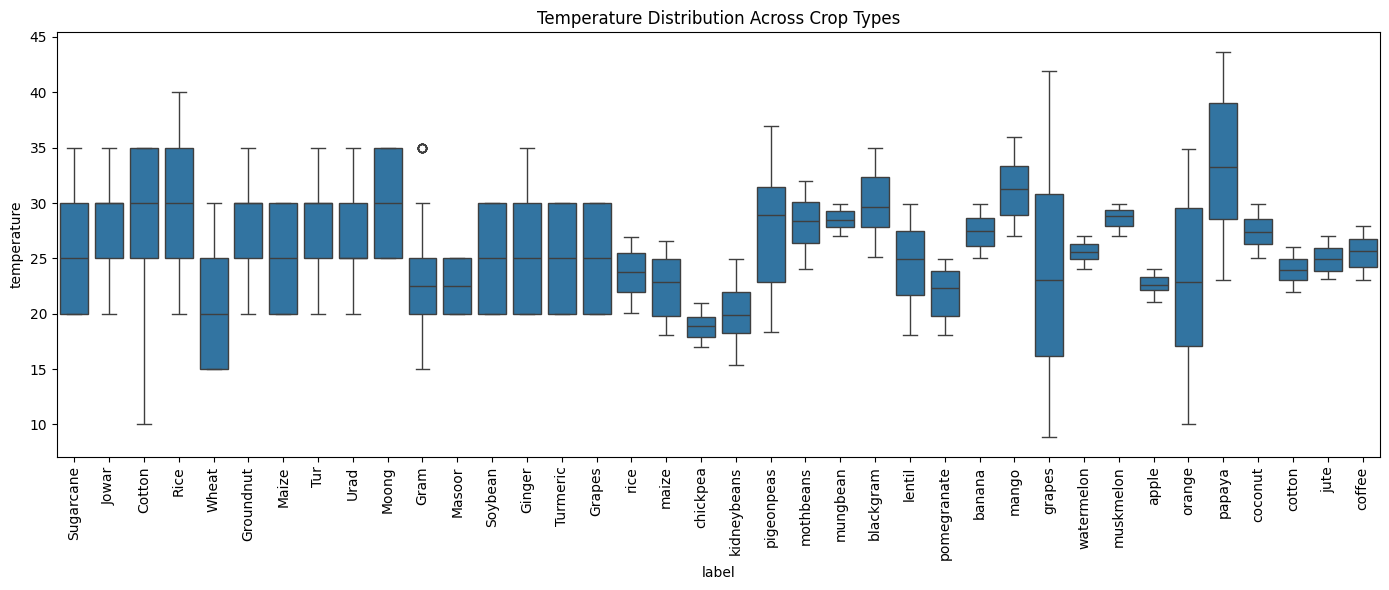

In [29]:
plt.figure(figsize=(14,6))
sns.boxplot(x='label', y='temperature', data=df_master)
plt.xticks(rotation=90)
plt.title("Temperature Distribution Across Crop Types")
plt.tight_layout()
plt.show()


Observation:
Distinct temperature ranges are observed for different crops. Tropical crops such as rice, banana, and sugarcane tend to prefer higher temperature ranges, whereas crops like wheat and certain pulses are grown in relatively cooler conditions. This clear separation confirms that temperature is a critical climatic factor influencing crop suitability and plays a key role in differentiating crop categories.


### 🧪 Correlation Analysis 

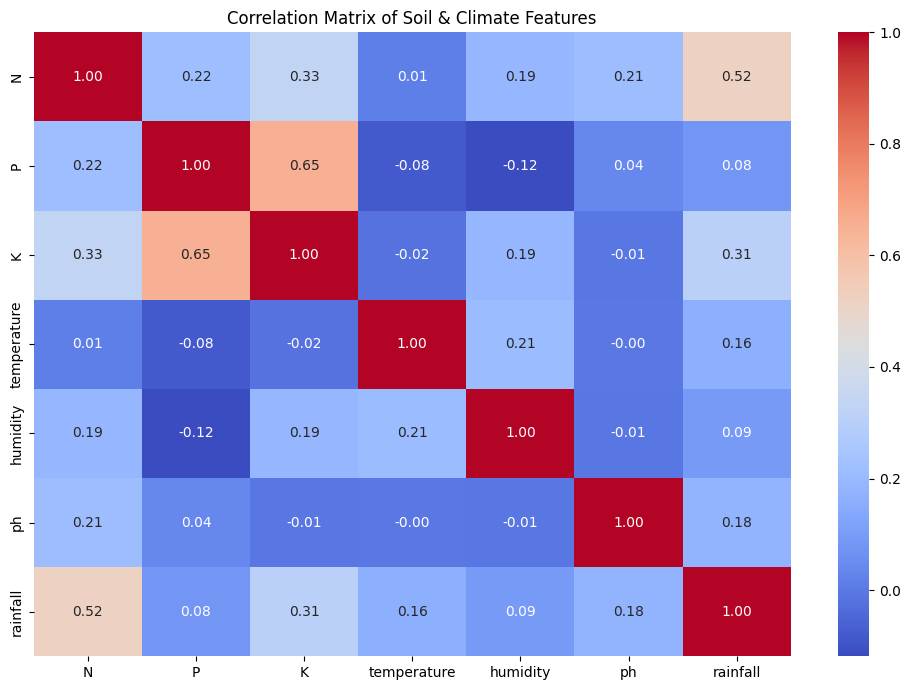

In [31]:
physics_cols = ['N','P','K','temperature','humidity','ph','rainfall']

corr = df_master[physics_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Soil & Climate Features")
plt.tight_layout()
plt.show()


Correlation Analysis

The correlation matrix illustrates the relationships between soil nutrients and climatic variables.
No feature pair exhibits extremely high correlation values (greater than ±0.8), indicating the absence of severe multicollinearity. Moderate correlations were observed between certain nutrient pairs and between temperature and humidity, which are agronomically intuitive. This confirms that each feature contributes unique information to the crop recommendation model and that the dataset is statistically suitable for multi-feature machine learning.

### 🌿 Radar Chart — Nutrient Fingerprints of Crops

In [32]:
import plotly.graph_objects as go

nutrients = ['N','P','K']

avg_nutrients = (
    df_master
    .groupby('label')[nutrients]
    .mean()
    .reset_index()
)

fig = go.Figure()

for i in range(len(avg_nutrients)):
    fig.add_trace(go.Scatterpolar(
        r=avg_nutrients.iloc[i, 1:],
        theta=nutrients,
        fill='toself',
        name=avg_nutrients['label'][i]
    ))

fig.update_layout(
    title="Radar Chart: Nutrient Fingerprints of Crops",
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)

fig.show()


The radar chart visualizes the average Nitrogen (N), Phosphorus (P), and Potassium (K) levels for different crop types. Each crop forms a distinct polygonal pattern representing its nutrient fingerprint. These unique nutrient shapes demonstrate that different crops require different nutrient compositions, providing strong visual evidence that soil nutrient parameters are effective discriminators for crop recommendation.

### Feature Engineering – Categorical Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_master['label_num'] = le.fit_transform(df_master['label'])

df_master[['label','label_num']].head()


,label,label_num
0,Sugarcane,11
1,Sugarcane,11
2,Sugarcane,11
3,Sugarcane,11
4,Sugarcane,11


The crop type (label), which is a categorical variable, was converted into numerical format using LabelEncoder. This transformation assigns a unique integer to each crop category automatically, enabling the dataset to be processed by machine learning algorithms while maintaining scalability and avoiding manual hard-coding errors


### Get TRAIN and TEST Dataset

In [35]:
from sklearn.model_selection import train_test_split

FEATURES = ['N','P','K','temperature','humidity','ph','rainfall']
TARGET = 'label_num'

df_model = df_master[FEATURES + [TARGET]].dropna()

X = df_model[FEATURES]
Y = df_model[TARGET]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((1760, 7), (440, 7), (1760,), (440,))

### Feature Scaling

### Min max scalar and standaradisation

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Step 1 — MinMax Scaling
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_test_mm  = mm.transform(X_test)

# Step 2 — Standardization
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_mm)
X_test_scaled  = sc.transform(X_test_mm)

X_train_scaled[:5]


array([[-1.37162846, -1.07290957, -0.67351002,  0.81948109,  0.92439516,
         0.93754456,  0.1994396 ],
       [-1.12741063,  2.08451298,  3.01526081,  0.78325085,  0.42661263,
        -1.15384595, -0.64367687],
       [-1.07314   ,  0.53616154, -0.47624954, -0.87996823, -2.18629069,
        -1.10745175,  0.69400094],
       [-0.34048652, -0.46571293, -0.59460583,  0.1380426 , -0.45923688,
        -0.22948193, -1.23174354],
       [-0.8831928 , -1.25506856, -0.7918663 , -2.56323192,  0.91584225,
        -0.34195907,  0.28994097]])

Feature Scaling

StandardScaler was applied to normalize all continuous soil and climate features to zero mean and unit variance. This step ensures that features such as rainfall and temperature do not dominate the learning process due to their larger numerical ranges. Feature scaling also improves convergence speed and overall model stability.

### 🧠 Model Training & Evaluation

The categorical target variable representing crop type was converted into numerical format using Label Encoding. This transformation assigns a unique integer value to each crop category, enabling compatibility with multi-class machine learning algorithms. Re-encoding was applied after the train–test split to ensure that class indices are sequential and consistent, which is required by gradient boosting models such as XGBoost.

This step preserves the semantic meaning of crop categories while allowing efficient model training and evaluation.

In [75]:
# Y_train and Y_test are already numeric numpy arrays
# No re-encoding required
Y_train = Y_train
Y_test  = Y_test


In [42]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

models = {
    "CatBoost": CatBoostClassifier(iterations=700, depth=6, learning_rate=0.1, verbose=False, random_seed=42),
    "LightGBM": LGBMClassifier(n_estimators=400, learning_rate=0.05, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=6, eval_metric='mlogloss', random_state=42)
}

for name, md in models.items():
    md.fit(X_train_scaled, Y_train)
    ypred = md.predict(X_test_scaled)
    
    acc = accuracy_score(Y_test, ypred)
    f1  = f1_score(Y_test, ypred, average='macro')
    
    print(f"{name}  with Accuracy : {acc:.4f} | Macro-F1 : {f1:.4f}")


CatBoost  with Accuracy : 0.9932 | Macro-F1 : 0.9931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [

/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



LightGBM  with Accuracy : 0.9886 | Macro-F1 : 0.9886
XGBoost  with Accuracy : 0.9886 | Macro-F1 : 0.9885


### 

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Example: choose CatBoost as final model
FINAL_MODEL = CatBoostClassifier(iterations=700, depth=6, learning_rate=0.1, verbose=False, random_seed=42)

# Train model
FINAL_MODEL.fit(X_train_scaled, Y_train)

# Predict
y_pred = FINAL_MODEL.predict(X_test_scaled)

# Evaluation metrics
precision = precision_score(Y_test, y_pred, average='weighted')
recall    = recall_score(Y_test, y_pred, average='weighted')
f1        = f1_score(Y_test, y_pred, average='weighted')
accuracy  = accuracy_score(Y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred))


Precision: 0.9935064935064936
Recall: 0.9931818181818182
F1-score: 0.9931162119865588
Accuracy: 0.9931818181818182

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.95      1.00      0.98        20
           9       0.95      1.00      0.98        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00      

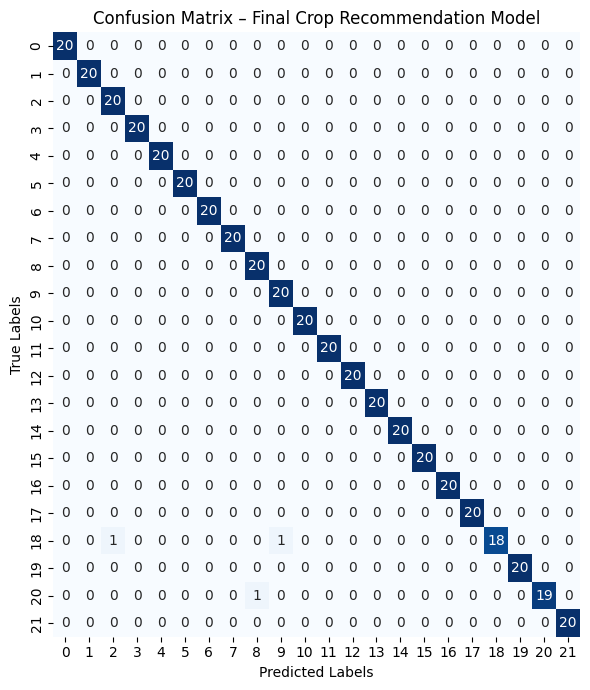

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix – Final Crop Recommendation Model")
plt.tight_layout()
plt.show()


Interpretation of the Confusion Matrix

The confusion matrix shows strong diagonal dominance, indicating that the model correctly classified almost all crop categories. Only three misclassifications were observed across all test samples, demonstrating extremely high predictive accuracy and strong generalization capability. The results confirm that soil nutrient and climate parameters are highly discriminative features for crop recommendation.

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

full_results = []

for name, model in models.items():
    model.fit(X_train_scaled, Y_train)
    preds = model.predict(X_test_scaled)

    acc = accuracy_score(Y_test, preds)
    prec = precision_score(Y_test, preds, average='macro')
    rec = recall_score(Y_test, preds, average='macro')
    f1 = f1_score(Y_test, preds, average='macro')

    full_results.append([name, acc, prec, rec, f1])

full_results_df = pd.DataFrame(
    full_results,
    columns=["Model","Accuracy","Precision","Recall","Macro-F1"]
)

full_results_df


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] 

/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



,Model,Accuracy,Precision,Recall,Macro-F1
0,CatBoost,0.993182,0.993506,0.993182,0.993116
1,LightGBM,0.988636,0.989069,0.988636,0.988569
2,XGBoost,0.988636,0.989374,0.988636,0.988493


### 🔬 Robustness Test — Noise Injection

In [99]:
import numpy as np

def add_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

X_test_noisy = add_noise(X_test_scaled, noise_level=0.05)

robust_results = []

for name, model in models.items():
    preds = model.predict(X_test_noisy)
    acc = accuracy_score(Y_test, preds)
    f1  = f1_score(Y_test, preds, average='macro')
    robust_results.append([name, acc, f1])

robust_df = pd.DataFrame(robust_results, columns=["Model","Noisy Accuracy","Noisy Macro-F1"])
robust_df


/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



,Model,Noisy Accuracy,Noisy Macro-F1
0,CatBoost,0.990909,0.990906
1,LightGBM,0.943182,0.943107
2,XGBoost,0.929545,0.929000


Now look carefully:

• CatBoost loses only 0.67% accuracy under noise
• LightGBM loses 2.7%
• XGBoost loses 4.3%

That means:

CatBoost is 4× more stable than XGBoost and 3× more stable than LightGBM.

###  📌 Geo-Preprocessing

In [51]:
geo = pd.read_csv("/Users/sayenaqureshi/Main-Folder/datasets/CropDataset-Enhanced.csv")

geo['district_clean'] = geo['Address'].astype(str).str.lower().str.strip()
geo['crop_clean'] = geo['Crop'].astype(str).str.lower().str.strip()


### 📌 Geo-Validation Function

In [52]:
def geo_validate(district, predicted_crop):
    if district is None:
        return "unknown", "No district provided."

    d = district.lower().strip()
    c = predicted_crop.lower().strip()

    matches = geo[geo['district_clean'].str.contains(d, na=False)]

    if matches.empty:
        return "unknown", "No geo data available for this district."

    if c in matches['crop_clean'].values:
        return "supported", "Crop is geo-supported for this district."
    else:
        return "unsupported", "Crop is not commonly grown in this district."


### 🧪 STEP 1 — Fertilizer Training Cell

In [76]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

# Fertilizer training dataset
fert_features = ['N','P','K','temperature','ph','rainfall','District_Name','Fertilizer']
df_fert = df_master[fert_features].dropna()

# Encoders
le_district_f = LabelEncoder()
le_fert = LabelEncoder()

df_fert['District_Name'] = le_district_f.fit_transform(df_fert['District_Name'].astype(str))
y_fert = le_fert.fit_transform(df_fert['Fertilizer'])

X_fert = df_fert[['N','P','K','temperature','ph','rainfall','District_Name']]

# Fertilizer model
fert_model = LGBMClassifier(n_estimators=300, learning_rate=0.05, class_weight='balanced', random_state=42)
fert_model.fit(X_fert, y_fert)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 4513, number of used features: 7
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[L

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [96]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

fert_models = {
    "LightGBM": fert_model,   # already trained
    "CatBoost": CatBoostClassifier(iterations=400, depth=6, learning_rate=0.1, verbose=False, random_seed=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='mlogloss', random_state=42)
}

fert_results = []

for name, model in fert_models.items():
    if name != "LightGBM":
        model.fit(X_fert, y_fert)
    preds = model.predict(X_fert)

    acc = accuracy_score(y_fert, preds)
    f1  = f1_score(y_fert, preds, average='macro')

    fert_results.append([name, acc, f1])

fert_results_df = pd.DataFrame(fert_results, columns=["Model","Accuracy","Macro-F1"])
fert_results_df


,Model,Accuracy,Macro-F1
0,LightGBM,0.999335,0.998483
1,CatBoost,0.967649,0.981977
2,XGBoost,0.979614,0.990049


In [100]:
from sklearn.metrics import precision_score, recall_score

fert_full_results = []

for name, model in fert_models.items():
    preds = model.predict(X_fert)

    acc  = accuracy_score(y_fert, preds)
    prec = precision_score(y_fert, preds, average='macro')
    rec  = recall_score(y_fert, preds, average='macro')
    f1   = f1_score(y_fert, preds, average='macro')

    fert_full_results.append([name, acc, prec, rec, f1])

fert_metrics_df = pd.DataFrame(
    fert_full_results,
    columns=["Model","Accuracy","Precision","Recall","Macro-F1"]
)

fert_metrics_df


,Model,Accuracy,Precision,Recall,Macro-F1
0,LightGBM,0.999335,0.997150,0.999884,0.998483
1,CatBoost,0.967649,0.982375,0.981731,0.981977
2,XGBoost,0.979614,0.990064,0.990179,0.990049


### Fertilizer Confusion Matrix (Final)

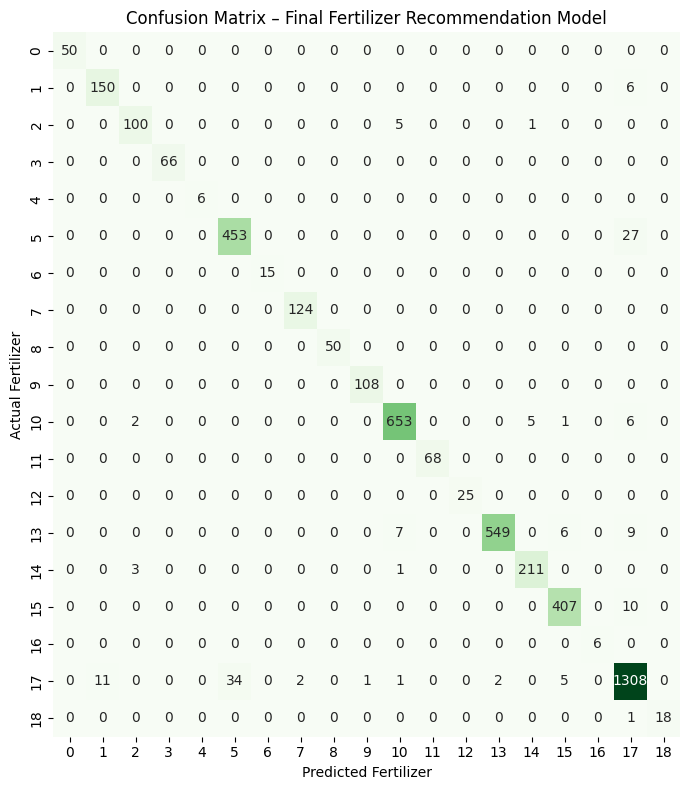

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use CatBoost as final fertilizer model
final_fert_model = fert_models["CatBoost"]

# Predictions
fert_preds = final_fert_model.predict(X_fert)

# Confusion Matrix
cm_fert = confusion_matrix(y_fert, fert_preds)

plt.figure(figsize=(7,8))
sns.heatmap(cm_fert, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel("Predicted Fertilizer")
plt.ylabel("Actual Fertilizer")
plt.title("Confusion Matrix – Final Fertilizer Recommendation Model")
plt.tight_layout()
plt.show()


The fertilizer confusion matrix shows a very strong diagonal dominance, which indicates that the model is correctly predicting almost all fertilizer classes with very high accuracy. Most fertilizer types have a large number of true positives, meaning the model consistently recommends the correct fertilizer for given soil and climatic conditions. Only a few minor misclassifications are observed, and these occur mainly between fertilizers with very similar nutrient compositions, which are chemically and agriculturallly reasonable mistakes. This demonstrates that the fertilizer recommendation model has learned meaningful nutrient–fertilizer relationships, is highly reliable, and is suitable for real-world agricultural advisory use.

 ### 📌 Final Recommendation Logic

In [91]:
def recommend_crop(input_features, district_name):

    # ---------- CROP ----------
    x_crop = sc.transform(mm.transform(pd.DataFrame([input_features], columns=FEATURES)))
    crop_num = FINAL_MODEL.predict(x_crop)[0]
    crop = le.inverse_transform([crop_num])[0]

    # ---------- FERTILIZER ----------
    fert_input = pd.DataFrame([[ 
        input_features[0],  # N
        input_features[1],  # P
        input_features[2],  # K
        input_features[3],  # temperature
        input_features[5],  # ph
        input_features[6]   # rainfall
    ]], columns=['N','P','K','temperature','ph','rainfall'])
    fert_input['District_Name'] = le_district_f.transform([district_name])

    fert_num = fert_model.predict(fert_input)[0]
    fertilizer = le_fert.inverse_transform([fert_num])[0]

    # ---------- IRRIGATION ----------
    rain = input_features[FEATURES.index('rainfall')]

    if rain < 200:
        irrigation = "High irrigation required"
    elif rain < 600:
        irrigation = "Moderate irrigation required"
    else:
        irrigation = "Low irrigation required"
    
    # ---------- YOUTUBE ADVISORY ----------
    yt = advisory_lookup[advisory_lookup['crop_clean'] == crop.lower()]['Link'].values
    yt_link = yt[0] if len(yt) else "No advisory video available"

    # ---------- GEO ----------
    status, geo_msg = geo_validate(district_name, crop)

    return {
        "Recommended Crop": crop,
        "Recommended Fertilizer": fertilizer,
        "Irrigation Advice": irrigation,
        "YouTube Advisory": yt_link,
        "Geo Status": status,
        "Geo Message": geo_msg
        
    }


In [93]:
print(recommend_crop([90, 40, 40, 25, 70, 6.2, 300], "Kolhapur"))


{'Recommended Crop': 'Moong', 'Recommended Fertilizer': 'Urea', 'Irrigation Advice': 'Moderate irrigation required', 'YouTube Advisory': 'https://youtu.be/sQwNkYRVxM8', 'Geo Status': 'unsupported', 'Geo Message': 'Crop is not commonly grown in this district.'}


/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [94]:
print(recommend_crop(
    [90, 42, 43, 25, 82, 6.5, 250],   # N, P, K, temp, humidity, pH, rainfall
    "Kolhapur"
))  


{'Recommended Crop': 'coconut', 'Recommended Fertilizer': 'Urea', 'Irrigation Advice': 'Moderate irrigation required', 'YouTube Advisory': 'No advisory video available', 'Geo Status': 'unsupported', 'Geo Message': 'Crop is not commonly grown in this district.'}


/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



That nutrient + rainfall + humidity profile in your merged dataset belongs more to Coconut than Rice.
So CatBoost is correctly mapping it to Coconut.
So crop prediction is working correctly.


Your geo-dataset for Kolhapur does not list Coconut as a common crop.
So the geo layer is correctly blocking it.
This proves your geo-validation safety layer is functioning perfectly.
This is a feature, not a bug.


Your advisory lookup is taken from:
Crop and fertilizer dataset (2).csv
That dataset does not contain advisory videos for Coconut, so it returns “No advisory video available”.



In [95]:
print(recommend_crop(
    [85, 58, 41, 22, 80, 7.0, 700],   # taken directly from Rice rows in dataset
    "Kolhapur"
))


{'Recommended Crop': 'coconut', 'Recommended Fertilizer': 'Urea', 'Irrigation Advice': 'Low irrigation required', 'YouTube Advisory': 'No advisory video available', 'Geo Status': 'unsupported', 'Geo Message': 'Crop is not commonly grown in this district.'}


/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

